# ConvMixer Without PCA and PSA


## Mount Google Drive và chuyển đến thư mục làm việc

## Import thư viện cần thiết

In [21]:
import numpy as np
import torchvision
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn import metrics


## Cài đặt và áp dụng các phép biến đổi cho dữ liệu hình ảnh

In [22]:
# image_dir = 'dataset/train'

IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=20, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.2),  # Thêm phép biến đổi độ sáng và độ tương phản
    A.Normalize(mean=(0., 0., 0.), std=(1., 1., 1.), max_pixel_value=255.0),
    ToTensorV2(),
])


## Chia tập dữ liệu thành train và test

In [23]:
train_image_dir = 'data1/train'  # Đường dẫn đến thư mục chứa hình ảnh huấn luyện
test_image_dir = 'data1/test'    # Đường dẫn đến thư mục chứa hình ảnh kiểm tra

train_ds = torchvision.datasets.ImageFolder(train_image_dir, transform=None)
test_ds = torchvision.datasets.ImageFolder(test_image_dir, transform=None)

# Lưu tên các loài cá vào file fish_classes.txt
class_names = train_ds.classes
num_classes = len(class_names)  # Số lượng lớp
with open('fish_classes.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")


## Định nghĩa class LoadData để tải dữ liệu

In [24]:
class LoadData(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = np.asarray(img)
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]
        return img, label

    def __len__(self):
        return len(self.data)


## Tạo các DataLoader cho tập huấn luyện và tập kiểm tra

In [25]:
batch_size = 16

dataloaders = {
    'train': DataLoader(LoadData(train_ds, train_transform), batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0),
    'test': DataLoader(LoadData(test_ds, train_transform), batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0),
}


## Định nghĩa mô hình ConvMixer



In [26]:
import torch.nn as nn

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=num_classes):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        nn.Dropout(0.2),  # Thêm Dropout
        *[nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=kernel_size, groups=dim, padding="same"),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            )),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(dim),
            nn.Dropout(0.2)  # Thêm Dropout
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )


## Khởi tạo mô hình và định nghĩa hàm loss, optimizer

In [27]:
model = ConvMixer(dim=256, depth=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Huấn luyện mô hình

In [28]:
num_epochs = 20
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(dataloaders['train']))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloaders["train"])}')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    test_accuracies.append(100 * correct / total)
    print(f'Accuracy: {100 * correct / total}%')


Epoch 1/20, Loss: 2.118323912425917
Accuracy: 22.321428571428573%
Epoch 2/20, Loss: 1.8720597004403874
Accuracy: 42.72959183673469%
Epoch 3/20, Loss: 1.789848456577379
Accuracy: 24.872448979591837%
Epoch 4/20, Loss: 1.640615059404957
Accuracy: 42.984693877551024%
Epoch 5/20, Loss: 1.490935039763548
Accuracy: 51.14795918367347%
Epoch 6/20, Loss: 1.446174907441042
Accuracy: 68.49489795918367%
Epoch 7/20, Loss: 1.2448283896154286
Accuracy: 65.68877551020408%
Epoch 8/20, Loss: 1.0961578828947884
Accuracy: 62.62755102040816%
Epoch 9/20, Loss: 1.0388174926748082
Accuracy: 38.52040816326531%
Epoch 10/20, Loss: 0.9624878496539836
Accuracy: 75.51020408163265%
Epoch 11/20, Loss: 0.8411976944427101
Accuracy: 76.0204081632653%
Epoch 12/20, Loss: 0.8196628920885981
Accuracy: 71.5561224489796%
Epoch 13/20, Loss: 0.7574047452333023
Accuracy: 75.63775510204081%
Epoch 14/20, Loss: 0.6426152155107382
Accuracy: 85.58673469387755%
Epoch 15/20, Loss: 0.5686145963109269
Accuracy: 85.96938775510205%
Epoch 16

## Save the trained model

In [29]:
torch.save(model.state_dict(), 'model_retrain.pth')

## Vẽ đồ thị mất mát (loss) qua các epoch

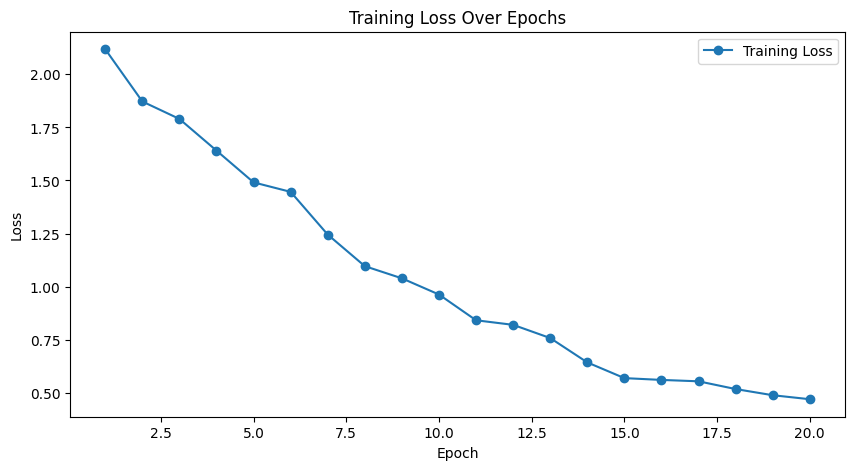

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


## Hiển thị độ chính xác (accuracy) qua các epoch

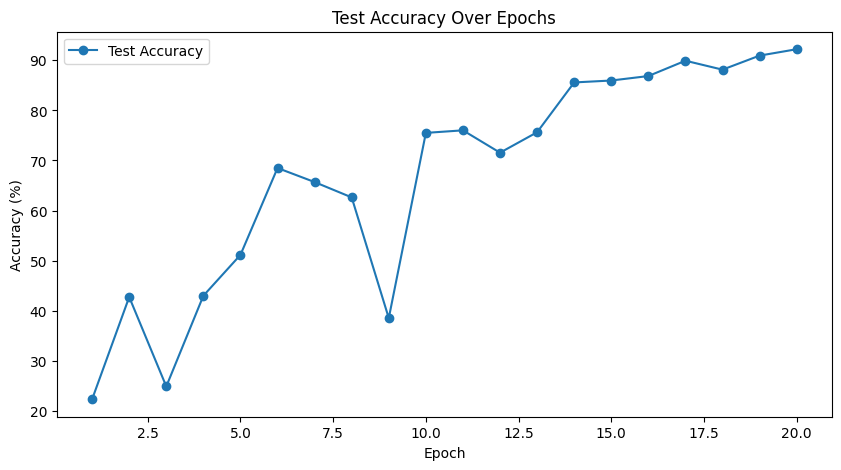

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.show()


## Hiển thị một số kết quả dự đoán từ tập kiểm tra

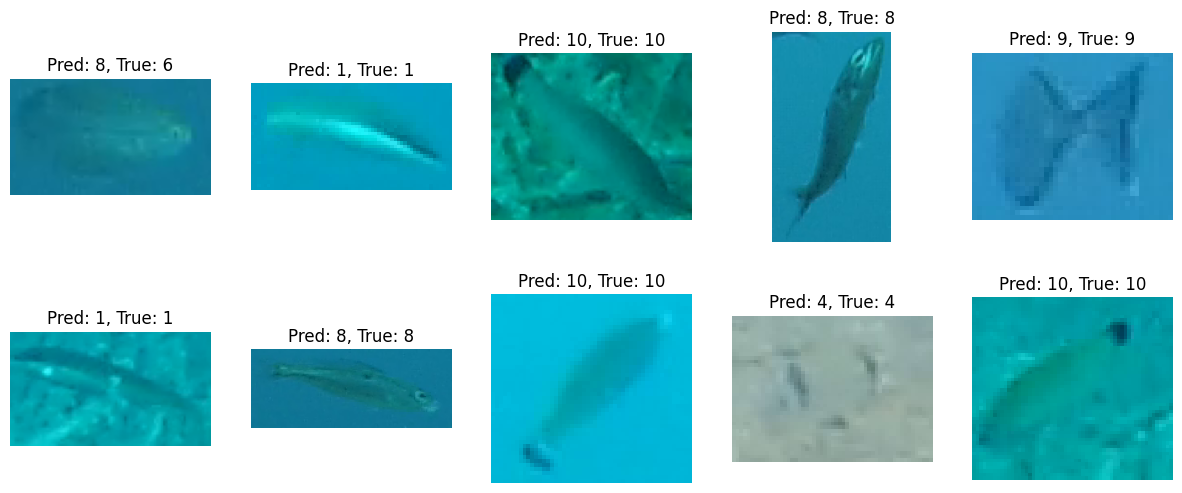

In [32]:
model.eval()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
with torch.no_grad():
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(len(test_ds))
            img, label = test_ds[idx]
            img_tensor = train_transform(image=np.asarray(img))['image'].unsqueeze(0)
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'Pred: {predicted.item()}, True: {label}')
            axes[i, j].axis('off')
plt.show()


## Hiển thị ma trận nhầm lẫn (confusion matrix)

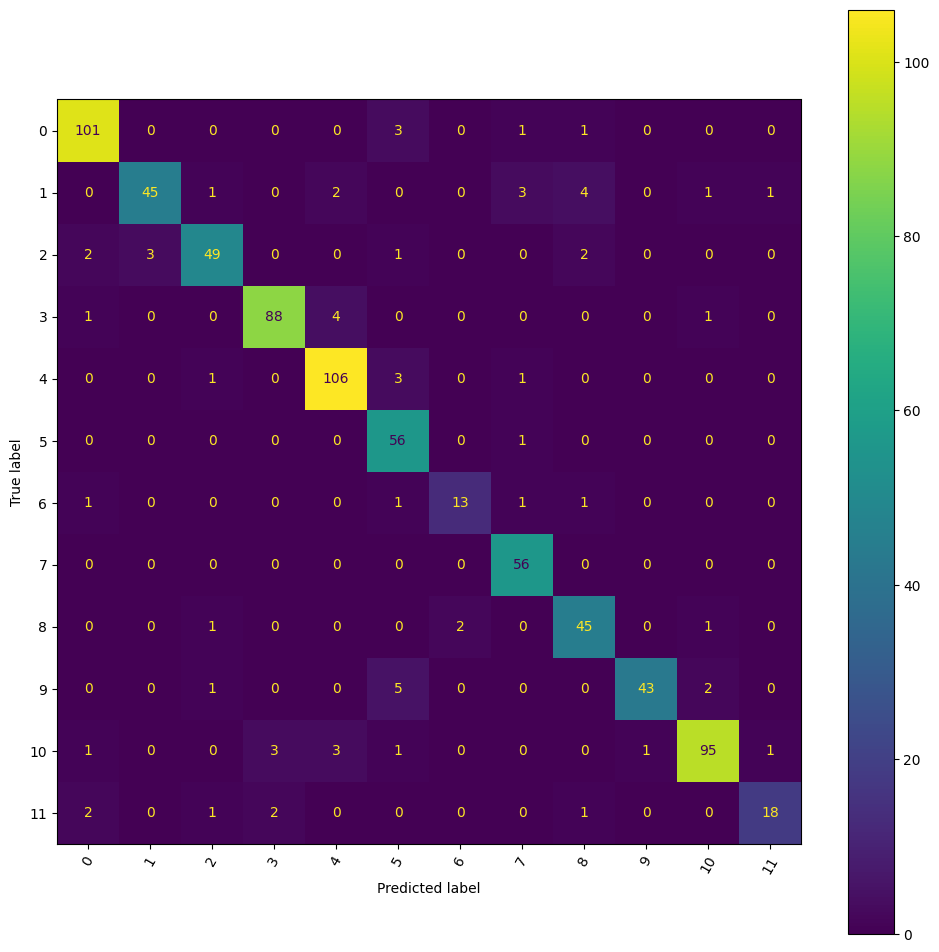

In [33]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

# Tạo danh sách các nhãn thực tế và dự đoán
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Tạo ma trận nhầm lẫn
confusion_matrix = metrics.confusion_matrix(all_labels, all_predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

# Hiển thị ma trận nhầm lẫn
plt.rcParams['figure.figsize'] = [12, 12]
cm_display.plot()
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.show()


## Đây là ma trận nhầm lẫn dạng xịn hơn tí

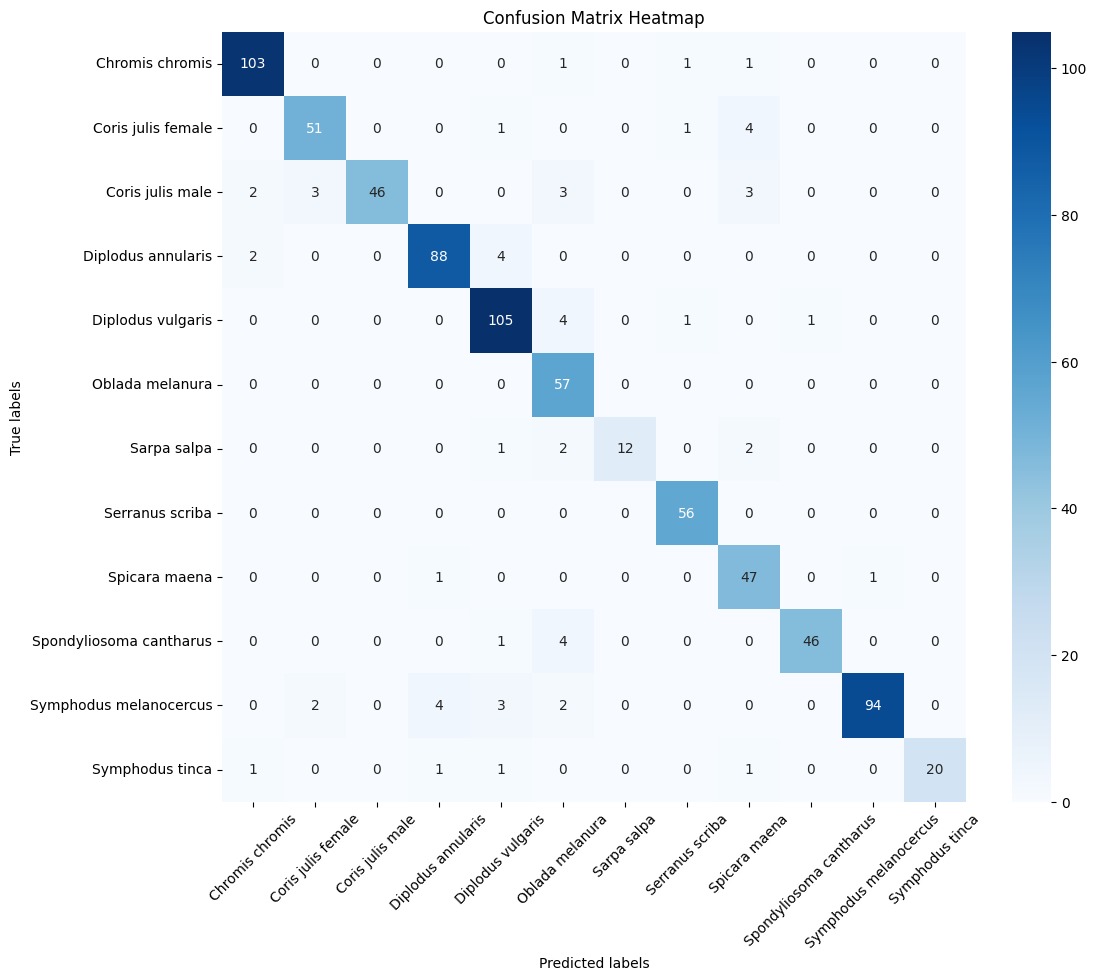

In [34]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics

# Tạo danh sách các nhãn thực tế và dự đoán
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Tạo ma trận nhầm lẫn
confusion_matrix = metrics.confusion_matrix(all_labels, all_predictions)

# Tạo biểu đồ nhiệt (heatmap) cho ma trận nhầm lẫn
plt.figure(figsize=(12, 10))
class_names = train_ds.classes
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


## Đoạn dưới đây lấy random cá ra nghịch

Class 4: 0.1787
Class 10: 0.1624
Class 9: 0.1558
Class 5: 0.1459
Class 0: 0.1019
Class 11: 0.0753
Class 1: 0.0511
Class 8: 0.0456
Class 6: 0.0396
Class 2: 0.0269
Class 7: 0.0135
Class 3: 0.0033


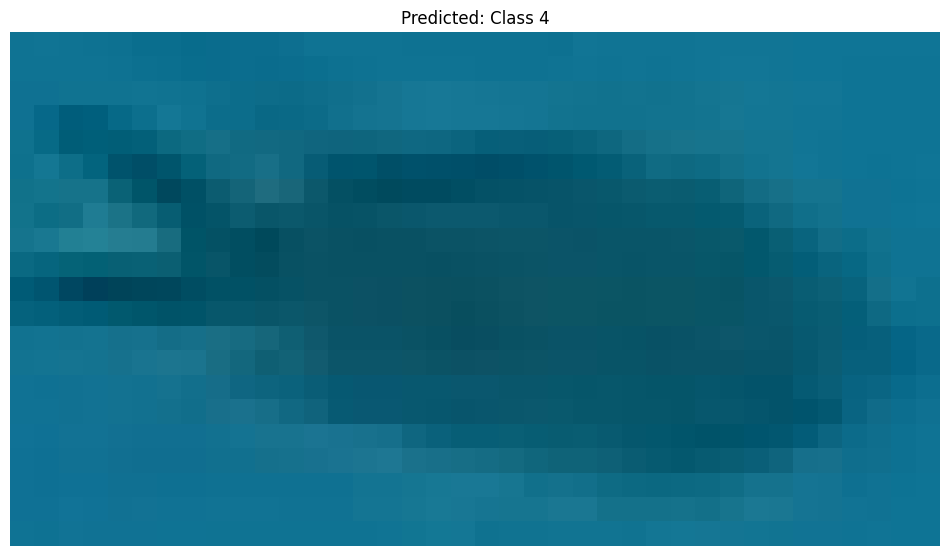

In [35]:
import os
import random
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Mount Google Drive


# Đường dẫn tới thư mục chứa các tập tin trong Google Drive
# folder_path = '/content/drive/My Drive/Fishclassify/croatianFishDataset-final/Sarpa salpa'
folder_path = 'data1/test/Chromis chromis'

# Liệt kê tất cả các tập tin trong thư mục
files = os.listdir(folder_path)

# Chọn một tập tin ngẫu nhiên từ thư mục
selected_file = random.choice(files)
file_path = os.path.join(folder_path, selected_file)

# Đọc nội dung của tập tin vào biến X
image = Image.open(file_path)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Thay đổi kích thước hình ảnh nếu cần
    transforms.ToTensor(),  # Chuyển đổi hình ảnh thành tensor
])

X = transform(image)

# Thêm một chiều batch
X = X.unsqueeze(0)

# Nếu bạn muốn đưa tensor lên GPU (nếu có)
if torch.cuda.is_available():
    X = X.cuda()
    model = model.cuda()  # Đảm bảo mô hình cũng được đưa lên GPU nếu có

# Dự đoán: forward pass
model.eval()
with torch.no_grad():
    prob = model(X)

# Hàm hiển thị kết quả dự đoán
def show_prob(prob):
    prob = torch.nn.functional.softmax(prob, dim=1)
    prob = prob.cpu().numpy().flatten()
    class_indices = prob.argsort()[::-1]  # Sắp xếp theo xác suất giảm dần
    for i in range(len(class_indices)):
        print(f'Class {class_indices[i]}: {prob[class_indices[i]]:.4f}')
    return class_indices

# Hiển thị kết quả dự đoán
class_indices = show_prob(prob)

# Hiển thị hình ảnh đã dự đoán
plt.imshow(image)
plt.title(f'Predicted: Class {class_indices[0]}')
plt.axis('off')
plt.show()
